In [51]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from utils.system import *

In [52]:
data = pd.read_parquet(get_data() / 'clean_data.parquet.brotli')

In [53]:
X = data['cleaned_article']
y = data['overall_label']

X

id
0       red streak girl. so uh yeah she seems pretty c...
1           just wanna talk. i'm here to talk if you want
2       how to get over jealousy of socially active fr...
3       were all lonely people, right? saw a post on h...
4       i hate my birthdaymy birthday is in two days a...
                              ...                        
7994     hello. how are you today? and how was your day? 
7995    i have nobody and nothing to live for. at this...
7996    26m [friendship] - clean audio chat - depressi...
7997    i forgot how to make friends. it's been so lon...
7998    please. hi. if anyone can keep me company toni...
Name: cleaned_article, Length: 7999, dtype: object

In [54]:
#tfidf_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
#X_tfidf = tfidf_vectorizer.fit_transform(X)

#lsa = TruncatedSVD(n_components=300, random_state=42)
#X_lsa = lsa.fit_transform(X_tfidf)

#SMOTE (Synthetic Minority Over-sampling Technique) is a popular technique used to address class imbalance in datasets, and it's available in the imbalanced-learn library. 
#smote = SMOTE(random_state=42)
#X_augmented, y_augmented = smote.fit_resample(X_lsa, y)

#X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

#param_grid = {
#    'hidden_layer_sizes': [(100,), (200,), (100, 50), (150, 75)],
#    'alpha': [0.0001, 0.001, 0.01],
#}

In [55]:
cv = CountVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X = cv.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (100, 50), (150, 75)],
    'alpha': [0.0001, 0.001, 0.01],
}

mlp_classifier = MLPClassifier(max_iter=500, random_state=42)

grid_search = GridSearchCV(mlp_classifier, param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_hidden_layer_sizes = grid_search.best_params_['hidden_layer_sizes']
best_alpha = grid_search.best_params_['alpha']

mlp_classifier = MLPClassifier(hidden_layer_sizes=best_hidden_layer_sizes, alpha=best_alpha, max_iter=500, random_state=42)

voting_classifier = VotingClassifier(estimators=[('mlp', mlp_classifier)], voting='hard')

voting_classifier.fit(X_train, y_train)

y_pred = voting_classifier.predict(X_test)

# Print the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[783 206]
 [249 362]]


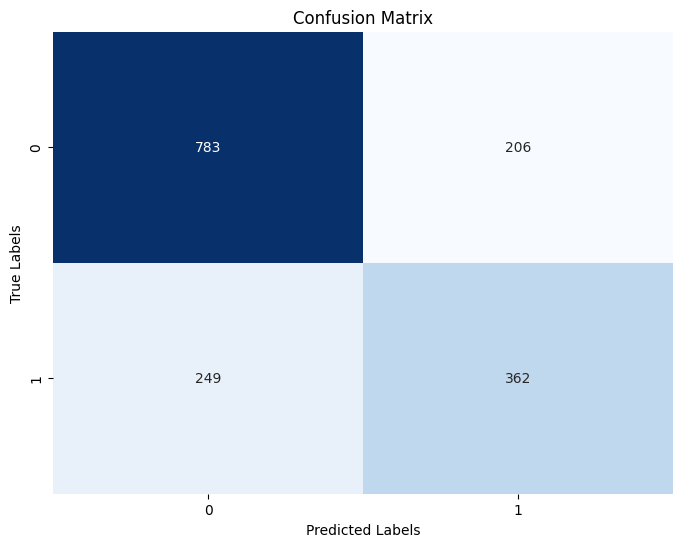

In [57]:

# Print the confusion matrix as a heatmap using Seaborn
confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [58]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred)

print("Test Set Accuracy:", accuracy)
print("Test Set F1 Score:", f1)
print("Test Set Precision:", precision[1])
print("Test Set Recall:", recall[1])
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Set Accuracy: 0.715625
Test Set F1 Score: 0.6140797285835455
Test Set Precision: 0.6373239436619719
Test Set Recall: 0.5924713584288053
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       989
           1       0.64      0.59      0.61       611

    accuracy                           0.72      1600
   macro avg       0.70      0.69      0.69      1600
weighted avg       0.71      0.72      0.71      1600

